In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import pmdarima as pm
import saxpy
import nltk
from nltk import bigrams
from nltk import trigrams
from saxpy.sax import sax_via_window
from saxpy.sax import sax_via_window
from saxpy.alphabet import cuts_for_asize
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn import preprocessing as pp

sns.set(rc={'figure.figsize':(11.7,8.27)})

## Reading the datasets

df1 = pd.read_csv("data/BATADAL_dataset03.csv")
df2 = pd.read_csv("data/BATADAL_dataset04.csv")
df2.columns = df2.columns.str.replace(" ", "")
dftest = pd.read_csv("data/BATADAL_test_dataset.csv")

In [3]:
## Add the right attack flags
new_attack_df2 = df2[['DATETIME', 'ATT_FLAG']].copy().set_index("DATETIME")
new_attack_df2['ATT_FLAG'] = 0

attack_points = [
    ["13/09/16 23", "16/09/16 00"],
    ["26/09/16 11", "27/09/16 10"],
    ["09/10/16 09", "11/10/16 20"],
    ["29/10/16 19", "02/11/16 16"],
    ["26/11/16 17", "29/11/16 04"],
    ["06/12/16 07", "10/12/16 04"],
    ["14/12/16 15", "19/12/16 04"]
]

for attack_point in attack_points:
    new_attack_df2.loc[attack_point[0]:attack_point[1], 'ATT_FLAG'] = 1
    
new_attack_df2.reset_index(inplace=True)

new_attack_df_test = dftest[['DATETIME']].copy().set_index("DATETIME")
new_attack_df_test['ATT_FLAG'] = 0

attack_points = [
    ["16/01/17 09", "19/01/17 06"],
    ["30/01/17 08", "02/02/17 00"],
    ["09/02/17 03", "10/02/17 09"],
    ["12/02/17 01", "13/02/17 07"],
    ["24/02/17 05", "28/02/17 08"],
    ["10/03/17 14", "13/03/17 21"],
    ["25/03/17 20", "27/03/17 01"]
]

for attack_point in attack_points:
    new_attack_df_test.loc[attack_point[0]:attack_point[1], 'ATT_FLAG'] = 1
    
new_attack_df_test.reset_index(inplace=True)

df2['ATT_FLAG'] = new_attack_df2['ATT_FLAG']
dftest['ATT_FLAG'] = new_attack_df_test['ATT_FLAG']

In [4]:
def predict_ARMA(training_features, features):\
    return None

In [5]:
def predict_Discrete(training_features, test_features):
    return None

In [32]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

def pcatest(n_components, traindata, testdata):
    pca = PCA(n_components=n_components)

    X_train_PCA = pca.fit_transform(traindata)
    X_test_PCAd = pd.DataFrame(data=pca.transform(testdata), index=testdata.index)

    X_test_PCAd_inverse = pca.inverse_transform(X_test_PCAd)
    X_test_PCAd_inverse = pd.DataFrame(data=X_test_PCAd_inverse, index=testdata.index)
    return X_test_PCAd_inverse,X_test_PCAd

def predict_PCA(training_features, test_features):
    n_components = 4
    
    X_test_PCAd_inverse, X_test_PCAd = pcatest(n_components,training_features,test_features)
    anomalyScoresPCA = anomalyScores(test_features, X_test_PCAd_inverse)
    
    threshold = 0.3
    return anomalyScoresPCA > threshold

In [33]:
train_df = df2[df2["ATT_FLAG"]==0].drop(columns=["DATETIME", "ATT_FLAG"])
test_df = dftest.drop(columns=["DATETIME", "ATT_FLAG"])
train_labels = df2['ATT_FLAG']
test_labels = dftest['ATT_FLAG']

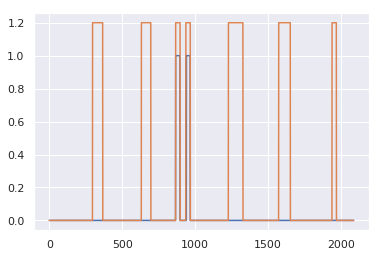

In [34]:
## PCA predictions

fig, ax = plt.subplots()
sns.lineplot(data=predict_PCA(train_df, test_df), ax=ax)
sns.lineplot(data=test_labels*1.2, ax=ax)